# Predicting Parking Occupancy Rates

Smart cities now have technology that can tell whether parking spots are occupied.  In some cities in the UK, such as Birmingham, nearly every parking spot has one of these detectors.  The detectors are connected to a server that can keep track of overall usage.

An obvious question for an individual driver may be: when and where will parking be available?

In order to predict an answer to this question, we will make a predictive model using Time Series analysis.

Specifically, we will try two models:
+ ARIMA (Autoregressive integrated moving average)
+ SARIMA (Seasonal ARIMA).


# Import Data

## Data Description

The dataset includes parking area occupancy and capacity for various locations in Birmingham, UK.

Each observation includes a date and time, ranging from October 4, 2016 through December 19, 2016 and for times from about 8:00AM to 4:30PM.  The measurements were taken every half hour, but not at exactly 0:00 and 0:30 times.


This dataset was obtained from the UCI Machine Learning Database and was compiled by Daniel H. Stolfi at the University of Malaga - Spain.  The original source of the data is from the Birmingham City Council government website.

https://data.birmingham.gov.uk/dataset/birmingham-parking/resource/bea04cd0-ea86-4d7e-ab3b-2da3368d1e01

https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham#


+ Daniel H. Stolfi, Enrique Alba, and Xin Yao. Predicting Car Park Occupancy Rates in Smart Cities. In: Smart Cities: Second International Conference, Smart-CT 2017, MÃ¡laga, Spain, June 14-16, 2017, pp. 107â€“117. doi> 10.1007/978-3-319-59513-9_11 
+ Birmingham City Council. [Web Link]



## Download Data

In [1]:
# Only needs to be run once to download the data, unless you are working on Google Colab
# uncomment below to download (For UNIX systems)

#!curl https://archive.ics.uci.edu/ml/machine-learning-databases/00482/dataset.zip --create-dirs -o  ./data/dataset.zip
#!unzip ./data/dataset.zip -d ./data/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  234k  100  234k    0     0   202k      0  0:00:01  0:00:01 --:--:--  202k
Archive:  ./data/dataset.zip
  inflating: ./data/dataset.csv      


# Import Data to Pandas Dataframe

In [1]:
# Import libraries and custom functions defined in Workbook_Init.py
from Workbook_Init import *

In [2]:
df_raw = pd.read_csv('./data/dataset.csv')

## Data Inspection

Using the `.head` method, a sample of the dataset shows that we have the following information:
+ SystemCodeNumber - ID code for the parking area
+ Capacity - The number of parking spots available
+ Occupancy - The number of parkings spots actually occupied at the time
+ LastUpdated - The date and time of the observation

In [3]:
df_raw.head(10)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48
5,BHMBCCMKT01,577,177,2016-10-04 10:26:49
6,BHMBCCMKT01,577,219,2016-10-04 10:59:48
7,BHMBCCMKT01,577,247,2016-10-04 11:25:47
8,BHMBCCMKT01,577,259,2016-10-04 11:59:44
9,BHMBCCMKT01,577,266,2016-10-04 12:29:45


Using `len()` function, we can see how many observations there are:

In [4]:
len(df_raw)

35717

It is always a good idea to make sure your data is in the format that you would expect.  In our case, we would want the SystemCodeNumber to be a string (called object in Pandas).  The Capacity and Occupancy should be integers (int64 in Pandas).  And the LastUpdated field should be a datetime (datetime64 in Pandas).

Using the `.dtypes` attribute of the dataframe, we can see what the data type is for each column.

The LastUpdated field formatted as a string instead of a datetime.  This is common when importing dates from csv files with Pandas.  We can fix this in our next step.

In [5]:
df_raw.dtypes

SystemCodeNumber    object
Capacity             int64
Occupancy            int64
LastUpdated         object
dtype: object

## Data Cleaning

We already know that one thing we need to do is change LastUpdated to be a datetime type.

After doing so, there are a few additional features to add that will help with our analysis:
+ PercentOccupied - Ratio of Occupancy to Capacity.  We will want to make sure these values go from 0%-100%
+ Date - Only the date component of LastUpdated.  Used for checking the data.
+ DayOfWeek - An integer representing the day of the week.  (1 = Monday)
+ Date_Time_HalfHour - this field will round each time to the nearest half hour.  This will help when we aggregate accross all parking areas.
+ Time - Only the time component of the Date_Time_HalfHour.  Used for checking the data.

In [6]:
df_clean = df_raw.copy()
df_clean.LastUpdated = df_clean.LastUpdated.astype('datetime64')
df_clean['PercentOccupied'] = df_clean.Occupancy / df_clean.Capacity
df_clean['date'] = df_clean.LastUpdated.dt.date
df_clean['dayofweek'] = df_clean.LastUpdated.dt.dayofweek
df_clean['date_time_halfhour'] = df_clean.LastUpdated.dt.round('30min')
df_clean['time'] = df_clean.date_time_halfhour.dt.time

Again, use `.head()` to inspect a sample of the data and make sure our new fields behave as expected.

In [7]:
df_clean.head()

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,PercentOccupied,date,dayofweek,date_time_halfhour,time
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,0.105719,2016-10-04,1,2016-10-04 08:00:00,08:00:00
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,0.110919,2016-10-04,1,2016-10-04 08:30:00,08:30:00
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,0.138648,2016-10-04,1,2016-10-04 09:00:00,09:00:00
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,0.185442,2016-10-04,1,2016-10-04 09:30:00,09:30:00
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,0.259965,2016-10-04,1,2016-10-04 10:00:00,10:00:00


First, we will take a look at what times we have.  We expect to have times ranging from 8:00AM to 4:30PM (16:30 military time).

We can see from below taht there are a few times of 7:30AM, which we will discard.

In [8]:
df_clean.groupby('time').size()

time
07:30:00      30
08:00:00    2096
08:30:00    1971
09:00:00    1953
09:30:00    1983
10:00:00    1987
10:30:00    1985
11:00:00    1961
11:30:00    1988
12:00:00    1976
12:30:00    1982
13:00:00    1988
13:30:00    1958
14:00:00    1984
14:30:00    1989
15:00:00    1986
15:30:00    1985
16:00:00    1956
16:30:00    1959
dtype: int64

In [9]:
# filter out few 7:30 measurements
df_clean = df_clean[df_clean.time > datetime.time(7,30)]

In case there are any duplicates, we will use pandas `.drop_duplicates()` method to automatically remove any. 

It happens that there are 207 duplicates removed.

In [10]:
# drop duplicates
pre_len = len(df_clean)
df_clean = df_clean.drop_duplicates()

post_len = len(df_clean)

dropped_len = pre_len - post_len
print(dropped_len)

207


We also wanted to make sure that the Occupancy ranged from a minimum value of 0 to a maximum value of Capacity.  We can check along all of the observations by seeing whether PercentOccupied is between 0% and 100%.

In [11]:
# Note that some values are out of range of 0-100%
print('Minimum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.max()))

Minimum Percent Occupied: -1.67%
Maximum Percent Occupied: 104.13%


There were some values outside the range (probably due to malfunction equipment), so we will manually limit the data to be between 0 and the Capacity value.  After doing so, we do another check to make sure we are now ranging from 0% to 100% in the PercentOccupied field.

In [12]:
# Limit Occupancy to the range of zero to Capacity
df_clean.Occupancy = df_clean.apply(lambda x: max(0, min(x['Capacity'], x['Occupancy'])), axis=1)
df_clean['PercentOccupied'] = df_clean.Occupancy / df_clean.Capacity

# Re-check range
print('Minimum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df_clean.PercentOccupied.max()))

Minimum Percent Occupied: 0.00%
Maximum Percent Occupied: 100.00%


Let's take a look at a few graphs for each location to see what the trend in parking occupancy rates looks like.

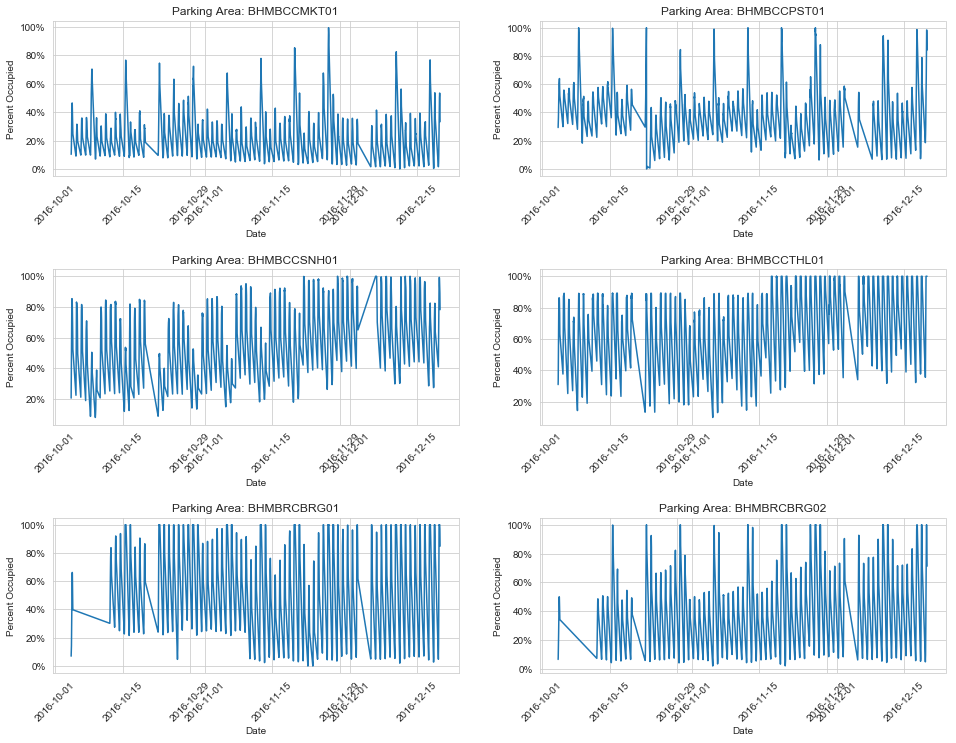

In [16]:
sample_plots_by_scn(df=df_clean, num_graphs=6, num_per_row=2)

In [0]:
df_agg_dthh = df.groupby('date_time_halfhour').agg({'Occupancy':['sum','count'], 'Capacity':['sum','count']})
df_agg_dthh['PercentOccupied'] = df_agg_dthh.Occupancy['sum'] / df_agg_dthh.Capacity['sum']

In [113]:
# Check for times when we dont have a big enough sample
df_agg_dthh[(df_agg_dthh.Occupancy['count']<20)|(df_agg_dthh.Capacity['sum']<25000)]



Occupancy       Capacity       PercentOccupied
                          sum count      sum count                
date_time_halfhour                                                
2016-10-28 08:00:00        10     1      450     1        0.022222
2016-12-13 13:30:00       663     1      720     1        0.920833

In [0]:
df_agg_dthh.drop(columns=['Occupancy', 'Capacity'], inplace=True)
df_agg_dthh.drop([pd.Timestamp('2016-10-28 08:00:00'), pd.Timestamp('2016-12-13 13:30:00')], inplace=True)

In [115]:
df_agg_dthh.head()

,PercentOccupied
,
date_time_halfhour,
2016-10-04 08:00:00,0.201437
2016-10-04 08:30:00,0.247512
2016-10-04 09:00:00,0.315444
2016-10-04 09:30:00,0.382376
2016-10-04 10:00:00,0.438917


In [128]:
temp = df_agg_dthh.reset_index()
temp['date'] = temp.date_time_halfhour.dt.date
temp['time'] = temp.date_time_halfhour.dt.time
temp = temp.groupby('date').count()
temp = pd.DataFrame(temp, index=pd.date_range('2016-10-04', '2016-12-19')).fillna(0)
temp[temp.date_time_halfhour<18]

# All of 10/20 and 10/21 are missing
# 10/30 missing 16:00 and 16:30
# 11/18 missing 9:00
# 11/25 missing 8:30
# 12/14 missing 11:00

# 10/28 and 12/13 dropped times as noted above

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,date_time_halfhour,PercentOccupied,time
,,,
2016-10-20,0.0,0.0,0.0
2016-10-21,0.0,0.0,0.0
2016-10-28,17.0,17.0,17.0
2016-10-30,16.0,16.0,16.0
2016-11-18,17.0,17.0,17.0
2016-11-25,17.0,17.0,17.0
2016-12-03,0.0,0.0,0.0
2016-12-04,0.0,0.0,0.0
2016-12-13,17.0,17.0,17.0


In [0]:
def fill_with_week_prior(df, column, year, month, day, hour, minutes):
  df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes)), column] = df.loc[pd.to_datetime(datetime.datetime(year, month, day-7, hour, minutes)), column]
  print(df.loc[pd.to_datetime(datetime.datetime(year, month, day-7, hour, minutes)), column])
  print(df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes)), column])

In [168]:
# fill in missing Percent Occupied with prior week's value for same time

# Also fill in for the under-reported times noted above

df_agg_fillmissing = df_agg_dthh.copy()


fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 21, 8, 0)




# # All of 10/20 and 10/21
# df_agg_fillmissing.loc[all_times_1020, 'PercentOccupied'] = df_agg_dthh.loc[all_times_1013, 'PercentOccupied']
# df_agg_fillmissing.loc[all_times_1021, 'PercentOccupied'] = df_agg_dthh.loc[all_times_1014, 'PercentOccupied']




# df_agg_fillmissing.loc[pd.to_datetime('2016-10-30 16:00:00', format='%Y-%m-%d %H:%M:%S'), 'PercentOccupied'] = df_agg_dthh.loc['2016-10-23 16:00:00', 'PercentOccupied']

# df_agg_fillmissing.loc[pd.to_datetime('2016-10-30 16:30:00', format='%Y-%m-%d %H:%M:%S'), 'PercentOccupied'] = df_agg_dthh.loc['2016-10-23 16:30:00', 'PercentOccupied']

# df_agg_fillmissing.loc[pd.to_datetime('2016-11-18 09:00:00', format='%Y-%m-%d %H:%M:%S'), 'PercentOccupied'] = df_agg_dthh.loc['2016-11-11 09:00:00', 'PercentOccupied']

# df_agg_fillmissing.loc[pd.to_datetime('2016-11-25 08:30:00', format='%Y-%m-%d %H:%M:%S'), 'PercentOccupied'] = df_agg_dthh.loc['2016-11-18 08:30:00', 'PercentOccupied']

# df_agg_fillmissing.loc[pd.to_datetime('2016-12-14 11:00:00', format='%Y-%m-%d %H:%M:%S'), 'PercentOccupied'] = df_agg_dthh.loc['2016-12-07 11:00:00', 'PercentOccupied']


# # Times with only one parking area reported
# # df_agg_fillmissing.loc[pd.to_datetime('2016-10-28 08:00:00', format='%Y-%m-%d %H:%M:%S'), 'PercentOccupied'] = df_agg_dthh.loc['2016-10-21 08:00:00', 'PercentOccupied']

# df_agg_fillmissing.loc[pd.to_datetime('2016-12-13 13:30:00', format='%Y-%m-%d %H:%M:%S'), 'PercentOccupied'] = df_agg_dthh.loc['2016-12-06 13:30:00', 'PercentOccupied']


df_agg_fillmissing.sort_index(inplace=True)


    0.213036
Name: 2016-10-14 08:00:00, dtype: float64
   NaN
Name: 2016-10-21 08:00:00, dtype: float64


In [166]:
df_agg_fillmissing

,PercentOccupied
,
date_time_halfhour,
2016-10-04 08:00:00,0.201437
2016-10-04 08:30:00,0.247512
2016-10-04 09:00:00,0.315444
2016-10-04 09:30:00,0.382376
2016-10-04 10:00:00,0.438917
2016-10-04 10:30:00,0.484684
2016-10-04 11:00:00,0.530015
2016-10-04 11:30:00,0.548390


In [130]:
df_agg_fillmissing.head()

,PercentOccupied
,
date_time_halfhour,
2016-10-04 08:00:00,0.201437
2016-10-04 08:30:00,0.247512
2016-10-04 09:00:00,0.315444
2016-10-04 09:30:00,0.382376
2016-10-04 10:00:00,0.438917


In [0]:
temp = df_agg_fillmissing.reset_index()
temp['date'] = temp.date_time_halfhour.dt.date
temp['time'] = temp.date_time_halfhour.dt.time
temp = temp.groupby('date').count()
temp[temp.date_time_halfhour<18]

,date_time_halfhour,PercentOccupied,time
date,,,


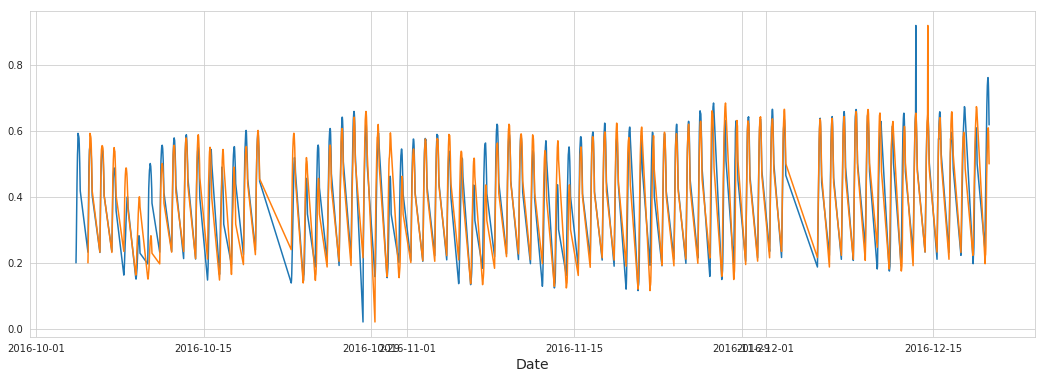

In [0]:
plt.figure(figsize=(18,6))
plt.plot(df_agg_fillmissing)
plt.plot(df_agg_fillmissing.shift(18))
plt.xlabel('Date', fontsize=14);

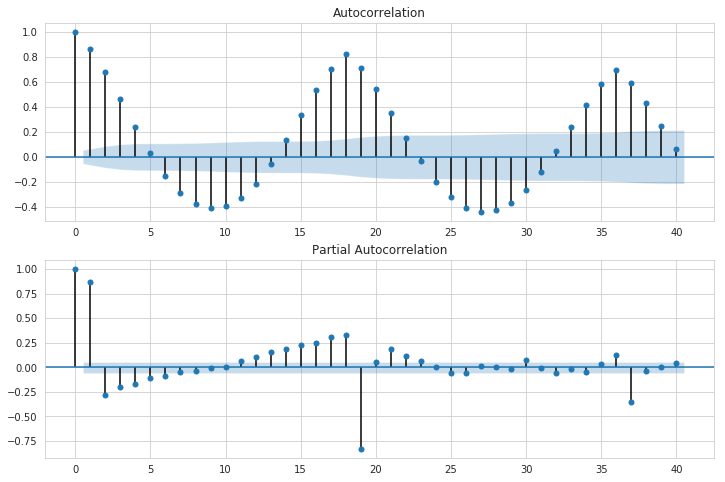

In [0]:
# plot_acf(df_agg_fillmissing);

# plot_pacf(df_agg_fillmissing);

subplots_acf_pacf(df_agg_fillmissing)

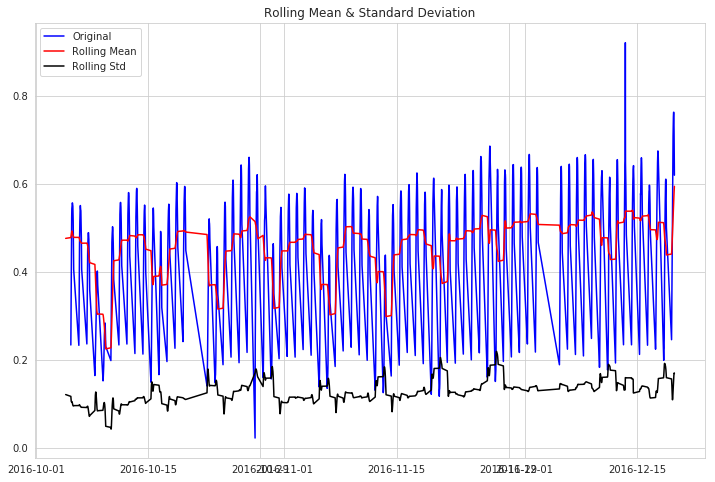

Results of Dickey-Fuller Test:
Test Statistic                   -3.660692
p-value                           0.004701
#Lags Used                       22.000000
Number of Observations Used    1291.000000
Critical Value (1%)              -3.435425
Critical Value (5%)              -2.863781
Critical Value (10%)             -2.567963
dtype: float64


In [0]:
test_stationarity(df_agg_fillmissing.squeeze(), 18)

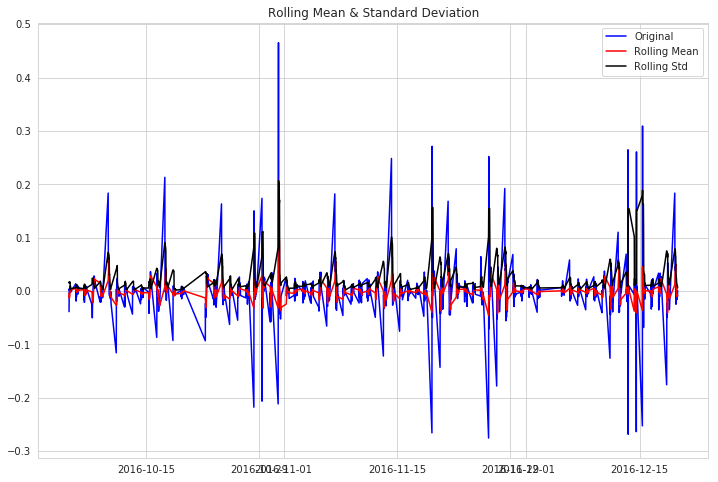

Results of Dickey-Fuller Test:
Test Statistic                -1.477767e+01
p-value                        2.270952e-27
#Lags Used                     1.800000e+01
Number of Observations Used    1.271000e+03
Critical Value (1%)           -3.435505e+00
Critical Value (5%)           -2.863817e+00
Critical Value (10%)          -2.567982e+00
dtype: float64


In [0]:
test_stationarity(df_agg_dthh.diff(18).diff().dropna().squeeze(), 7)

In [0]:
# Train-Test Split
# Sklearn built in split for time series

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)


data_use = df_agg_fillmissing.reset_index()['PercentOccupied']

for train_index, test_index in tscv.split(data_use):
  train = data_use[train_index]
  test = data_use[test_index]


TimeSeriesSplit(max_train_size=None, n_splits=5)


In [0]:
train.index = df_agg_fillmissing.index[:len(train)]
train.tail()

date_time_halfhour
2016-12-07 13:00:00    0.655717
2016-12-07 13:30:00    0.659830
2016-12-07 14:00:00    0.655278
2016-12-07 14:30:00    0.640535
2016-12-07 15:00:00    0.608282
Name: PercentOccupied, dtype: float64

In [0]:
test.index = df_agg_fillmissing.index[len(train):]
test.head()

date_time_halfhour
2016-12-07 15:30:00    0.574477
2016-12-07 16:00:00    0.538965
2016-12-07 16:30:00    0.490934
2016-12-08 08:00:00    0.208799
2016-12-08 08:30:00    0.250975
Name: PercentOccupied, dtype: float64

In [0]:
# Define and fit ARIMA model
arima_model = ARIMA(train, order=(18, 1, 0))
results_AR = arima_model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


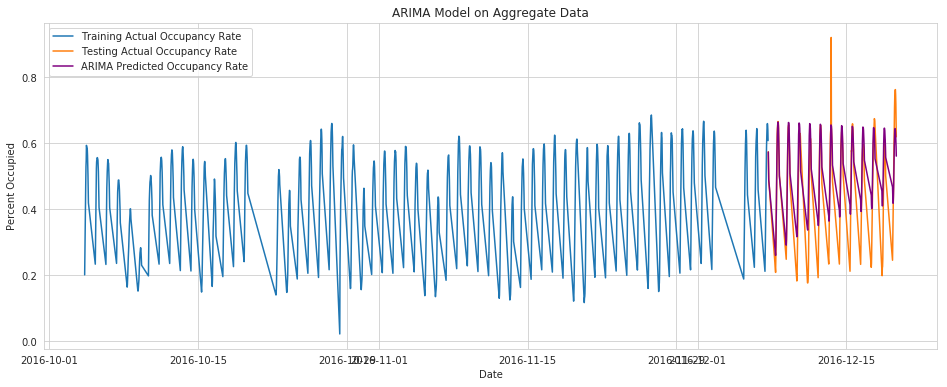

-----------------------------------------------------------------------------
ARIMA Model Metrics on Test Data
Explained Variance:
	 0.7551267021290652
MAE:
	 0.05623307967511758
RMSE:
	 0.08128180379001855
MAPE:
	 16.578134796566708
r^2:
	 0.7096281468517148


In [53]:
plt.figure(figsize=(16,6))
plt.title('ARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_AR = pd.Series(results_AR.forecast(steps=len(test))[0], index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate')
plt.plot(y_pred, color='purple', label='ARIMA Predicted Occupancy Rate')
plt.legend()

plt.show()


print('-'*77)
print('ARIMA Model Metrics on Test Data')
print('='*77)
report_metrics(test.squeeze(), y_pred.squeeze())

In [59]:
pd.DataFrame(list(zip(test.index, test, y_pred_AR, y_pred_AR-test)), columns=['Date_Time', 'Predicted', 'Actual', 'Difference'])

,Date_Time,Predicted,Actual,Difference
0,2016-12-07 15:30:00,0.574477,0.573587,-0.000890
1,2016-12-07 16:00:00,0.538965,0.535939,-0.003026
2,2016-12-07 16:30:00,0.490934,0.487901,-0.003034
3,2016-12-08 08:00:00,0.208799,0.260405,0.051605
4,2016-12-08 08:30:00,0.250975,0.288850,0.037876
5,2016-12-08 09:00:00,0.314352,0.331804,0.017452
6,2016-12-08 09:30:00,0.364520,0.382224,0.017703
7,2016-12-08 10:00:00,0.437096,0.446459,0.009363
8,2016-12-08 10:30:00,0.515675,0.501104,-0.014571
9,2016-12-08 11:00:00,0.571806,0.563190,-0.008616


In [0]:
# Define and fit ARIMA model
my_seasonal_order = (1, 1, 1, 18)
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=my_seasonal_order)
results_SAR = sarima_model.fit(disp=-1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


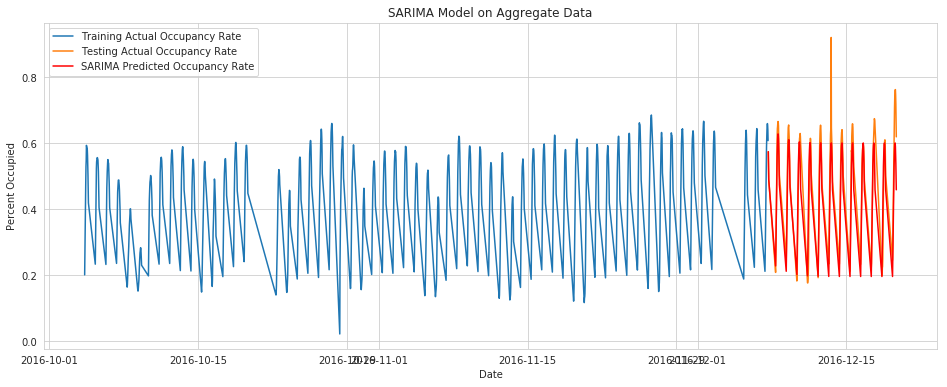

-----------------------------------------------------------------------------
SARIMA Model Metrics on Test Data
Explained Variance:
	 0.827200763648146
MAE:
	 0.05292028839441015
RMSE:
	 0.0692817478169382
MAPE:
	 11.62923748880932
r^2:
	 0.7890373746911354


In [54]:
plt.figure(figsize=(16,6))
plt.title('SARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_sar = pd.Series(results_SAR.forecast(steps=len(test)).values, index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate')
plt.plot(y_pred_sar, color='red', label='SARIMA Predicted Occupancy Rate')
plt.legend()

plt.show()


print('-'*77)
print('SARIMA Model Metrics on Test Data')
print('='*77)
report_metrics(test.squeeze(), y_pred_sar.squeeze())

In [64]:
df_SAR_results = pd.DataFrame(list(zip(test.index, y_pred_sar, test, y_pred_sar-test)), columns=['Date_Time', 'Predicted', 'Actual', 'Difference'])
df_SAR_results['Absolute_Diff'] = np.abs(df_SAR_results.Difference)
df_SAR_results.sort_values('Absolute_Diff', ascending=False)

,Date_Time,Predicted,Actual,Difference,Absolute_Diff
104,2016-12-13 13:30:00,0.600144,0.920833,-0.320690,0.320690
182,2016-12-17 16:30:00,0.459198,0.647990,-0.188792,0.188792
62,2016-12-11 10:30:00,0.450588,0.266308,0.184280,0.184280
61,2016-12-11 10:00:00,0.401371,0.219690,0.181681,0.181681
216,2016-12-19 15:30:00,0.538160,0.718909,-0.180749,0.180749
215,2016-12-19 15:00:00,0.566642,0.746696,-0.180054,0.180054
214,2016-12-19 14:30:00,0.589488,0.762891,-0.173403,0.173403
217,2016-12-19 16:00:00,0.503576,0.667912,-0.164337,0.164337
181,2016-12-17 16:00:00,0.503576,0.667002,-0.163425,0.163425
213,2016-12-19 14:00:00,0.600937,0.761781,-0.160844,0.160844


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


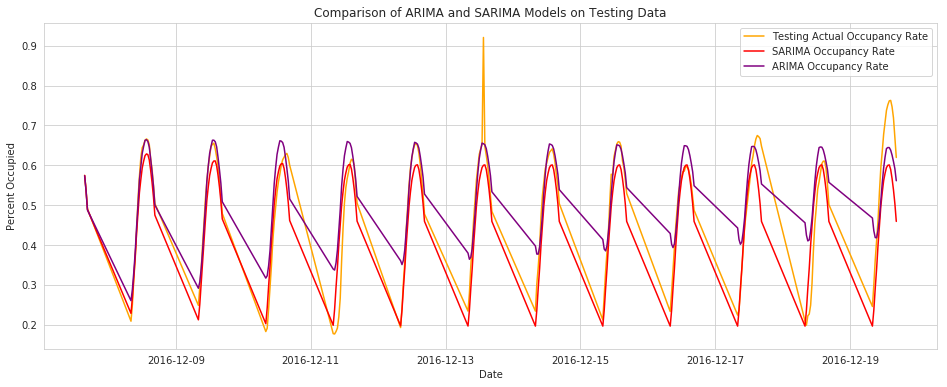

In [58]:
plt.figure(figsize=(16,6))
plt.title('Comparison of ARIMA and SARIMA Models on Testing Data')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_sar = pd.Series(results_SAR.forecast(steps=len(test)).values, index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate', color='orange')
plt.plot(y_pred_sar, color='red', label='SARIMA Occupancy Rate')

y_pred_AR = pd.Series(results_AR.forecast(steps=len(test))[0], index=test.index)
plt.plot(y_pred_AR, color='purple', label='ARIMA Occupancy Rate')

plt.legend()

plt.show()



In [68]:
df[(df.date==datetime.date(2016,12,13)) & (df.time==datetime.time(13, 30))]

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,PercentOccupied,date,dayofweek,Month,date_time_halfhour,time
15233,BHMNCPLDH01,720,663,2016-12-13 13:29:56,0.920833,2016-12-13,1,12,2016-12-13 13:30:00,13:30:00
